In [1]:
import math
import numpy as np
import pickle
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
from scipy.misc import imresize
from skimage import feature

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

In [2]:
# helpers

# plot images, list are dislayed in subplots
def plot(imgs, title=None):
    # make sure input is a list
    if not isinstance(imgs, list):
        imgs = [imgs]
    
    plt.figure()
        
    for i in range(len(imgs)):
        if(title is not None): 
            plt.suptitle(title)
        plt.subplot(1, len(imgs), i+1)
        plt.axis("off")
        plt.imshow(imgs[i])
        

# create empty list of given size
def empty(size):
    return [None]*size

# load data set
def load_data(set_name, chunk):
    
    data = pickle.load(open("./data_pp/%s_%i.pkl" % (set_name, chunk), 'rb'))
    
    print('load_set: loaded %i samples' % data['n_samples'])
    
    return data
    
# dump feature set
def dump_features(set_name, chunk, features):
    
    pickle.dump(features, open("./features/%s_%i.pkl" % (set_name, chunk), 'wb'))

    
print('done')

done


In [ ]:
def hog(img):
    
    orientations=8
    pixels_per_cell=(20,20)
    cells_per_block=(2,2)
    
    return feature.hog(img, orientations, pixels_per_cell, cells_per_block, visualise=False)
    

def sift(img):
    
    pixelStepSize = 10
    
    sift = cv2.xfeatures2d.SIFT_create()
    
    keypointGrid = [cv2.KeyPoint(x, y, pixelStepSize)
                    for y in range(0, img.shape[0], pixelStepSize)
                        for x in range(0, img.shape[1], pixelStepSize)]
    
#     (kp, descriptions) = sift.compute(img, keypointGrid)
    
    return sift.compute(img, keypointGrid)[1]

In [3]:
# make sure memory is cleared
try:
    print('memory: cleared')
    del data
except:
    print('memory: nothing loaded')

# choose data_set to be used
set_name = 'train'
chunk = 0

# load data
data = load_data(set_name, chunk)

print('done')

memory: cleared
memory: nothing loaded


FileNotFoundError: [Errno 2] No such file or directory: './data_pp/train_0.pkl'

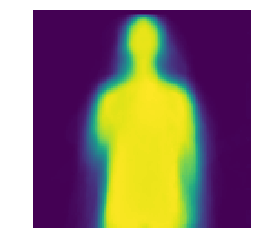

In [7]:
mean = np.zeros((120,120))
for i in r:
    label = data['label'][i]
    if data['valid'][i] and label == 10:
        dep = data['dep'][i]
#         dep[dep==0] = 255
#         plot([data['rgb'][i], dep<123], label)
        mean += dep
        
plot(mean)
        

In [4]:
features = {'hog_dep':empty(c),'hog_depd':empty(c),'hog_rgb':empty(c),'sift_dense':empty(c)}

In [5]:
orientations=8
pixels_per_cell=(20,20)
cells_per_block=(2,2)

for i in r:
    if(not i%1000):
        print(i)
    
    if(not data['valid'][i]):
        continue
        
    dep = data['dep'][i]
    dep[dep==0] = 255
    
    d = 127
    while((dep<d).sum() > 500):
        d -= 1
    
#     features['hog_dep'], hog_dep = feature.hog(dep, orientations, pixels_per_cell, cells_per_block, visualise=True)
    features['hog_dep'][i] = feature.hog(dep, orientations, pixels_per_cell, cells_per_block, visualise=False)
#     features['hog_depd'], hog_depd = feature.hog(dep<d, orientations, pixels_per_cell, cells_per_block, visualise=True)
    features['hog_depd'][i] = feature.hog(dep<d, orientations, pixels_per_cell, cells_per_block, visualise=False)
    
    rgb = data['rgb'][i]
    rgb = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
    
#     features['hog_rgb'], hog_rgb = feature.hog(rgb, orientations, pixels_per_cell, cells_per_block, visualise=True)
    features['hog_rgb'][i] = feature.hog(rgb, orientations, pixels_per_cell, cells_per_block, visualise=False)
    
#     plot([hog_dep, hog_depd, hog_rgb])

print('done')

0
1000
2000
3000
4000
5000
6000
7000
8000
done


In [6]:
pixelStepSize=10

for i in r:
    if(not i%1000):
        print(i)
        
    if(not data['valid'][i]):
        continue 
    
    img = data['rgb'][i]
    
    # Create sift object.
    sift = cv2.xfeatures2d.SIFT_create()
    
    # Create grid of key points.
    keypointGrid = [cv2.KeyPoint(x, y, pixelStepSize)
                    for y in range(0, img.shape[0], pixelStepSize)
                        for x in range(0, img.shape[1], pixelStepSize)]
    
    # Given the list of keypoints, compute the local descriptions for every keypoint.
    (kp, descriptions) = sift.compute(img, keypointGrid)
    
#     print(len(descriptions))

    features['sift_dense'][i] = descriptions
    
print('done')
    

0
1000
2000
3000
4000
5000
6000
7000
8000


In [7]:
X = np.zeros((c, 2400+144*13))

In [8]:
print(np.array(range(128))[0::10])
print(features['sift_dense'][0][:, 0::10].ravel().shape)

[  0  10  20  30  40  50  60  70  80  90 100 110 120]
(1872,)


In [9]:
for i in r:
        
    if(not data['valid'][i]):
        continue
    
    X[i, 0:800] = features['hog_dep'][i]
    X[i, 800:1600] = features['hog_depd'][i]
    X[i, 1600:2400] = features['hog_rgb'][i]
    X[i, 2400:] = features['sift_dense'][i][:, 0::10].ravel()
    
print(X.shape)

(8190, 4272)


In [10]:
X[np.isnan(X)] = 0

In [42]:
Y = data['label']
print(Y.shape)

(38000,)


In [12]:
pickle.dump(X, open("./features/features-%s_2.pkl" % data_set, 'wb'))
# pickle.dump(Y, open("./features/labels-train.pkl", 'wb'))